<a href="https://colab.research.google.com/github/achrefdhibi/Named_Entity_Recognition_/blob/main/Named_Entity_Recognition_(NER).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, TimeDistributed, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import to_categorical

In [2]:
sns.set_style('darkgrid')


In [27]:
data = pd.read_csv(
    "/content/ner.csv", encoding = "ISO-8859-1", error_bad_lines=False,
    usecols=['sentence_idx', 'word', 'tag']
)
data  = data[data['sentence_idx'] != 'prev-lemma'].dropna(subset=['sentence_idx']).reset_index(drop=True)
print(data.shape)
data.head()

(28607, 3)


<ipython-input-27-70466193b19c>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(


,sentence_idx,word,tag
0,1.0,Thousands,O
1,1.0,of,O
2,1.0,demonstrators,O
3,1.0,have,O
4,1.0,marched,O


In [28]:
class SentenceGetter(object):

    def __init__(self, dataset, word_col, tag_col, sent_id_col):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [
            (w, t) for w,t in zip(s[word_col].values.tolist(), s[tag_col].values.tolist())
        ]
        self.grouped = self.dataset.groupby(sent_id_col).apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None


In [29]:
getter = SentenceGetter(dataset=data, word_col='word', tag_col='tag', sent_id_col='sentence_idx')
sentences = getter.sentences
print(sentences[0])


[('Thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('London', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('Iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


Number of Sentences: 1286
Maximum sequence length: 62
Number of unique words: 5443


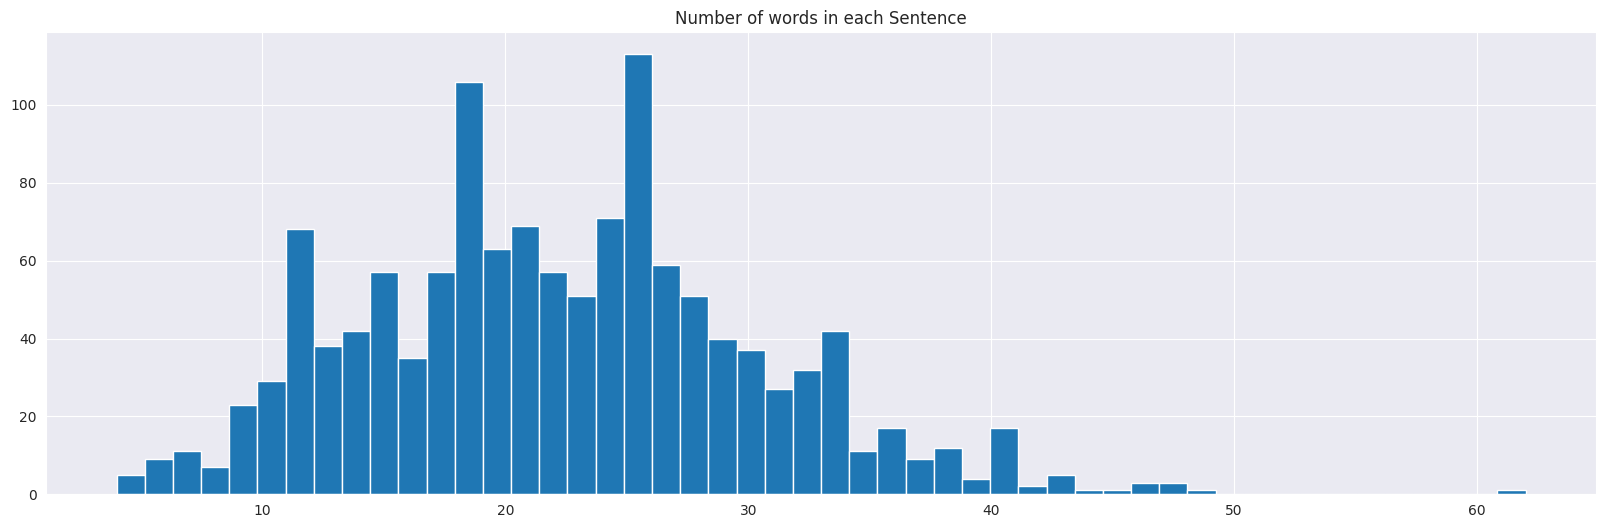

In [30]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.hist([len(s) for s in sentences], bins=50)
ax.set_title('Number of words in each Sentence')

maxlen = max([len(s) for s in sentences])
print('Number of Sentences:', len(sentences))
print ('Maximum sequence length:', maxlen)

words = list(set(data["word"].values))
words.append("ENDPAD")
n_words = len(words)
print('Number of unique words:', n_words)



Number of unique Tags: 17


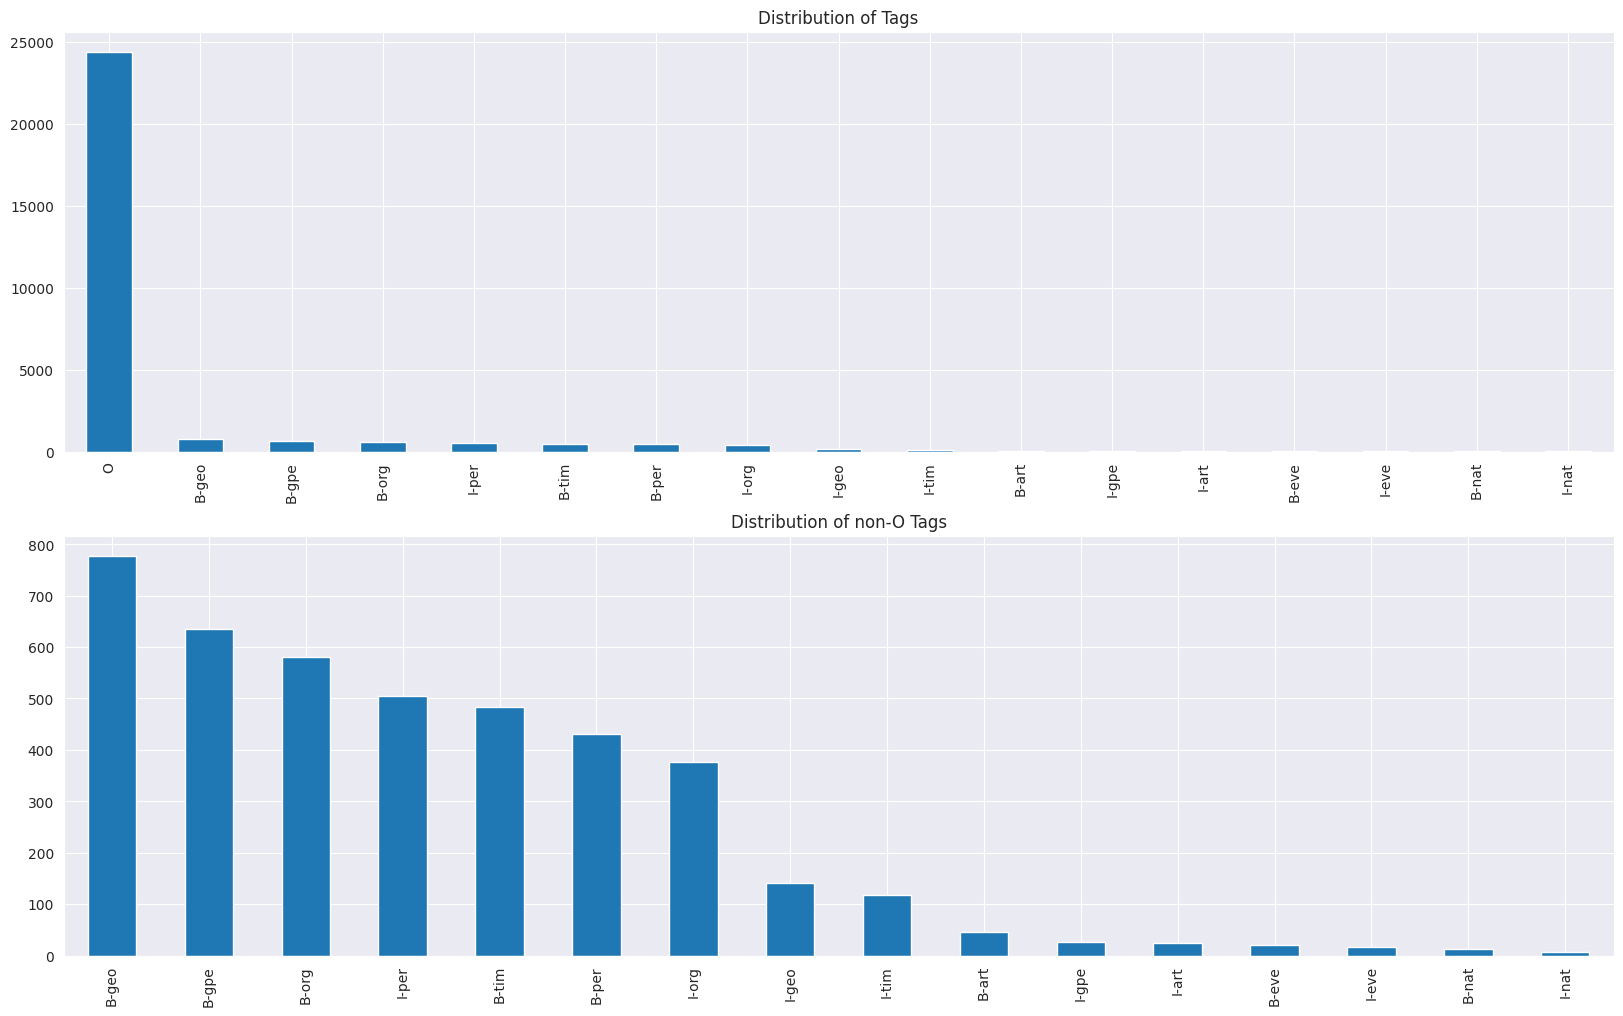

In [31]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12))
data.tag.value_counts().plot.bar(ax=ax[0], title='Distribution of Tags')
data[data.tag != 'O'].tag.value_counts().plot.bar(ax=ax[1], title='Distribution of non-O Tags')

tags = list(set(data["tag"].values))
n_tags = len(tags)
print('Number of unique Tags:', n_tags)





In [32]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}



In [34]:
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = sequence.pad_sequences(maxlen=maxlen, sequences=X, padding="post",value=n_words - 1)

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = sequence.pad_sequences(maxlen=maxlen, sequences=y, padding="post", value=tag2idx["O"])
y = np.array([to_categorical(i, num_classes=n_tags) for i in y])

print('X shape', X.shape, 'y shape', y.shape)

X shape (1286, 62) y shape (1286, 62, 17)


In [35]:
class config():
    VOCAB = n_words
    MAX_LEN = maxlen
    N_OUPUT = n_tags


    EMBEDDING_VECTOR_LENGTH = 50
    N_LSTM_CELLS = 64
    RECURRENT_DROPOUT = 0.1

    OUTPUT_ACTIVATION = 'softmax'

    LOSS = 'categorical_crossentropy'
    OPTIMIZER = 'adam'
    METRICS = ['accuracy']

    MAX_EPOCHS = 10

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 62, 50)            272150    
                                                                 
 bidirectional_1 (Bidirecti  (None, 62, 128)           58880     
 onal)                                                           
                                                                 
 time_distributed_1 (TimeDi  (None, 62, 17)            2193      
 stributed)                                                      
                                                                 
Total params: 333223 (1.27 MB)
Trainable params: 333223 (1.27 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


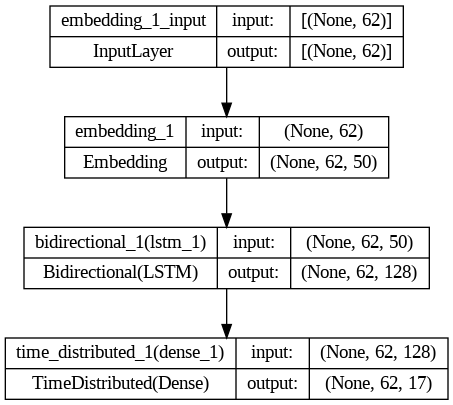

In [54]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)
filepath = "model.h5"
ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
rlp = ReduceLROnPlateau(monitor='loss', patience=3, verbose=1)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)
filepath = "model.h5"
ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
rlp = ReduceLROnPlateau(monitor='loss', patience=3, verbose=1)

model = Sequential()
model.add(
    Embedding(
        input_dim=config.VOCAB, output_dim=config.EMBEDDING_VECTOR_LENGTH, input_length=config.MAX_LEN
    )
)
model.add(
    Bidirectional(
        LSTM(config.N_LSTM_CELLS, return_sequences=True, recurrent_dropout=config.RECURRENT_DROPOUT)
    )
)
model.add(
    TimeDistributed(
        Dense(config.N_OUPUT, activation=config.OUTPUT_ACTIVATION)
    )
)
model.compile(loss=config.LOSS, optimizer=config.OPTIMIZER, metrics=config.METRICS)

model.summary()
plot_model(model, show_shapes=True)

In [40]:
history = model.fit(x=X, y=y, validation_split=0.1, callbacks=[es, ckpt, rlp], epochs=Config.MAX_EPOCHS)


Epoch 1/10
37/37 [==============================] - ETA: 0s - loss: 1.2983 - accuracy: 0.9080
Epoch 1: loss improved from inf to 1.29829, saving model to model.h5
37/37 [==============================] - 14s 214ms/step - loss: 1.2983 - accuracy: 0.9080 - val_loss: 0.3426 - val_accuracy: 0.9505 - lr: 0.0010
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


37/37 [==============================] - ETA: 0s - loss: 0.3225 - accuracy: 0.9470
Epoch 2: loss improved from 1.29829 to 0.32250, saving model to model.h5
37/37 [==============================] - 6s 168ms/step - loss: 0.3225 - accuracy: 0.9470 - val_loss: 0.2920 - val_accuracy: 0.9505 - lr: 0.0010
Epoch 3/10
37/37 [==============================] - ETA: 0s - loss: 0.2906 - accuracy: 0.9470
Epoch 3: loss improved from 0.32250 to 0.29058, saving model to model.h5
37/37 [==============================] - 7s 199ms/step - loss: 0.2906 - accuracy: 0.9470 - val_loss: 0.2682 - val_accuracy: 0.9505 - lr: 0.0010
Epoch 4/10
37/37 [==============================] - ETA: 0s - loss: 0.2612 - accuracy: 0.9470
Epoch 4: loss improved from 0.29058 to 0.26119, saving model to model.h5
37/37 [==============================] - 6s 168ms/step - loss: 0.2612 - accuracy: 0.9470 - val_loss: 0.2436 - val_accuracy: 0.9505 - lr: 0.0010
Epoch 5/10
37/37 [==============================] - ETA: 0s - loss: 0.2411 - a

Text(0.5, 0.98, 'Model Metrics')

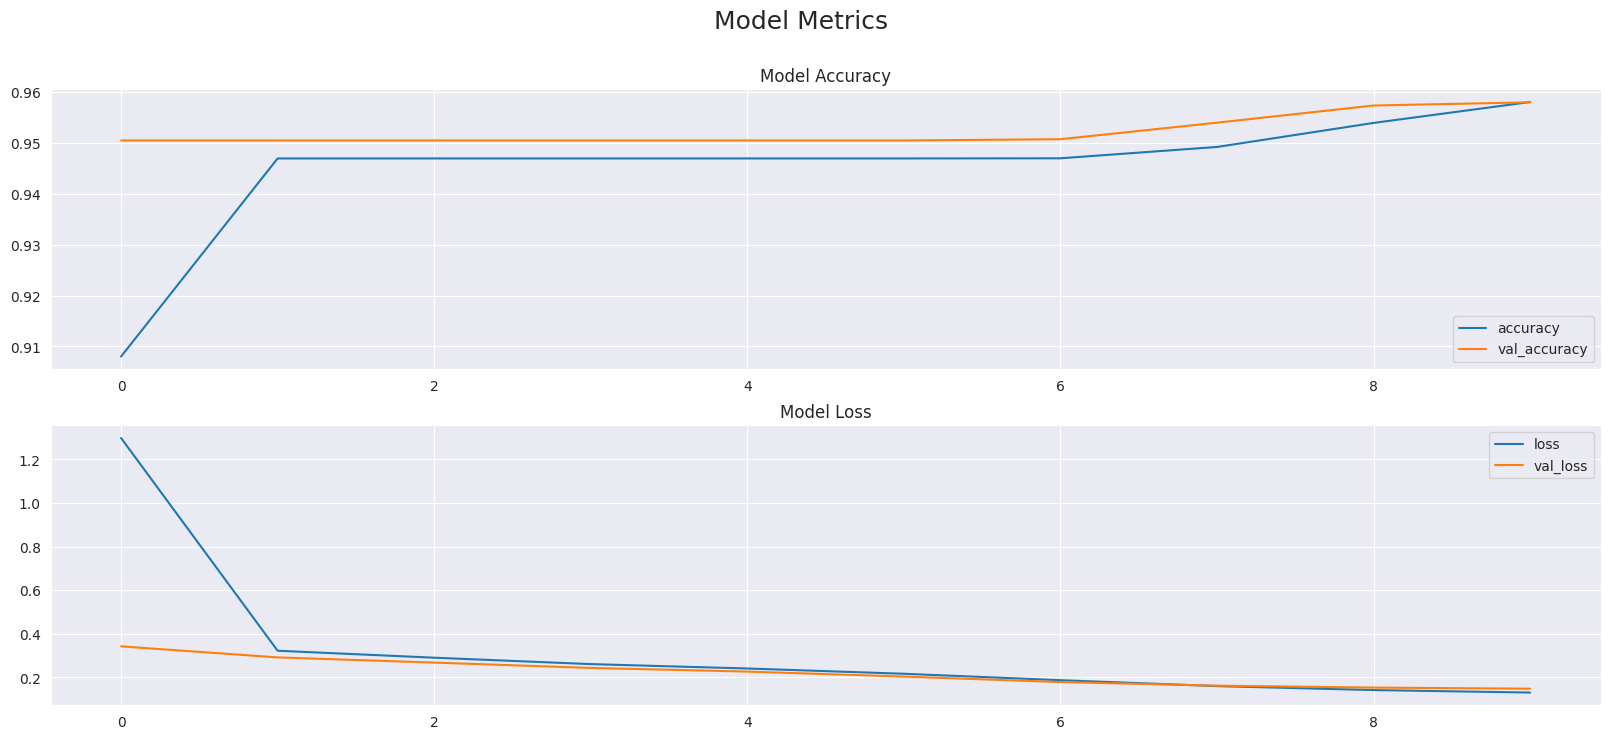

In [41]:
fig, ax = plt.subplots(2, 1, figsize=(20, 8))
df = pd.DataFrame(history.history)
df[['accuracy', 'val_accuracy']].plot(ax=ax[0])
df[['loss', 'val_loss']].plot(ax=ax[1])
ax[0].set_title('Model Accuracy', fontsize=12)
ax[1].set_title('Model Loss', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18)

In [42]:
i = np.random.randint(0, X.shape[0])
p = model.predict(np.array([X[i]]))
p = np.argmax(p, axis=-1)
y_true = np.argmax(y, axis=-1)[i]


1/1 [==============================] - 1s 717ms/step


In [43]:
print(f"{'Word':15}{'True':5}\t{'Pred'}")
print("-" * 30)
for (w, t, pred) in zip(X[i], y_true, p[0]):
    print(f"{words[w]:15}{tags[t]}\t{tags[pred]}")
    if words[w] == 'ENDPAD':
        break


Word           True 	Pred
------------------------------
Shinzo         B-per	O
Abe            I-per	O
,              O	O
acting         O	O
secretary      O	O
general        O	O
of             O	O
Japan          B-gpe	B-gpe
's             O	O
ruling         O	O
Liberal        B-org	O
Democratic     I-org	O
Party          I-org	I-per
,              O	O
said           O	O
Sunday         B-tim	B-gpe
that           O	O
it             O	O
would          O	O
be             O	O
"              O	O
unthinkable    O	O
"              O	O
for            O	O
Tokyo          B-gpe	B-geo
to             O	O
do             O	O
nothing        O	O
should         O	O
North          B-geo	B-geo
Korea          B-gpe	B-geo
conduct        O	O
such           O	O
a              O	O
test           O	O
.              O	O
ENDPAD         O	O


In [44]:
def extract_named_entities(words, tags):
    named_entities = []
    current_entity = None
    for word, tag in zip(words, tags):
        if tag != 'O':
            if current_entity is None:
                current_entity = (word, tag)
            else:
                current_entity = (current_entity[0] + ' ' + word, tag)
        elif current_entity is not None:
            named_entities.append(current_entity)
            current_entity = None
    if current_entity is not None:
        named_entities.append(current_entity)
    return named_entities

In [45]:
i = np.random.randint(0, X.shape[0])
p = model.predict(np.array([X[i]]))
p = np.argmax(p, axis=-1)
y_true = np.argmax(y, axis=-1)[i]


1/1 [==============================] - 0s 33ms/step


In [46]:
print("original sentence :")
for word, tag in zip(X[i], y_true):
    print(f"{words[word]}\t{tags[tag]}")


original sentence :
The	O
next	O
day	O
it	O
snowed	O
very	O
hard	O
,	O
so	O
that	O
he	O
could	O
not	O
take	O
the	O
herd	O
to	O
their	O
usual	O
feeding	O
places	O
,	O
but	O
was	O
obliged	O
to	O
keep	O
them	O
in	O
the	O
fold	O
.	O
ENDPAD	O
ENDPAD	O
ENDPAD	O
ENDPAD	O
ENDPAD	O
ENDPAD	O
ENDPAD	O
ENDPAD	O
ENDPAD	O
ENDPAD	O
ENDPAD	O
ENDPAD	O
ENDPAD	O
ENDPAD	O
ENDPAD	O
ENDPAD	O
ENDPAD	O
ENDPAD	O
ENDPAD	O
ENDPAD	O
ENDPAD	O
ENDPAD	O
ENDPAD	O
ENDPAD	O
ENDPAD	O
ENDPAD	O
ENDPAD	O
ENDPAD	O
ENDPAD	O
ENDPAD	O
